In [1]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection
!unzip brain-mri-images-for-brain-tumor-detection.zip

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection
License(s): copyright-authors
 79% 12.0M/15.1M [00:01<00:00, 17.2MB/s]
100% 15.1M/15.1M [00:01<00:00, 11.8MB/s]
Archive:  brain-mri-images-for-brain-tumor-detection.zip
  inflating: brain_tumor_dataset/no/1 no.jpeg  
  inflating: brain_tumor_dataset/no/10 no.jpg  
  inflating: brain_tumor_dataset/no/11 no.jpg  
  inflating: brain_tumor_dataset/no/12 no.jpg  
  inflating: brain_tumor_dataset/no/13 no.jpg  
  inflating: brain_tumor_dataset/no/14 no.jpg  
  inflating: brain_tumor_dataset/no/15 no.jpg  
  inflating: brain_tumor_dataset/no/17 no.jpg  
  inflating: brain_tumor_dataset/no/18 no.jpg  
  inflating: brain_tumor_dataset/no/19 no.jpg  
  inflating: brain_tumor_dataset/no/2 no.jpeg  
  inflating: brain_tumor_dataset/no/20 no.jpg  
  inflating: brain_tumor_

# **With VGG-16 Only**

In [ ]:
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess_input
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet50_preprocess_input
from tensorflow.keras.applications.inception_v3 import preprocess_input as inception_v3_preprocess_input


In [ ]:
from tensorflow.keras.applications.vgg16 import preprocess_input  # or other model-specific preprocess_input

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2

TRAIN_DIR = "/content/
/"

train_data_gen = ImageDataGenerator(validation_split=0.2, preprocessing_function=preprocess_input)

train_generator = train_data_gen.flow_from_directory(TRAIN_DIR,
                                                     target_size=(224, 224),
                                                     color_mode='rgb',
                                                     batch_size=32,
                                                     shuffle=True,
                                                     subset='training')

validation_generator = train_data_gen.flow_from_directory(TRAIN_DIR,
                                                          target_size=(224, 224),
                                                          color_mode='rgb',
                                                          batch_size=32,
                                                          shuffle=False,
                                                          subset='validation')


Found 203 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


In [ ]:
labels = train_generator.class_indices
class_mapping = dict((v, k) for k, v in labels.items())

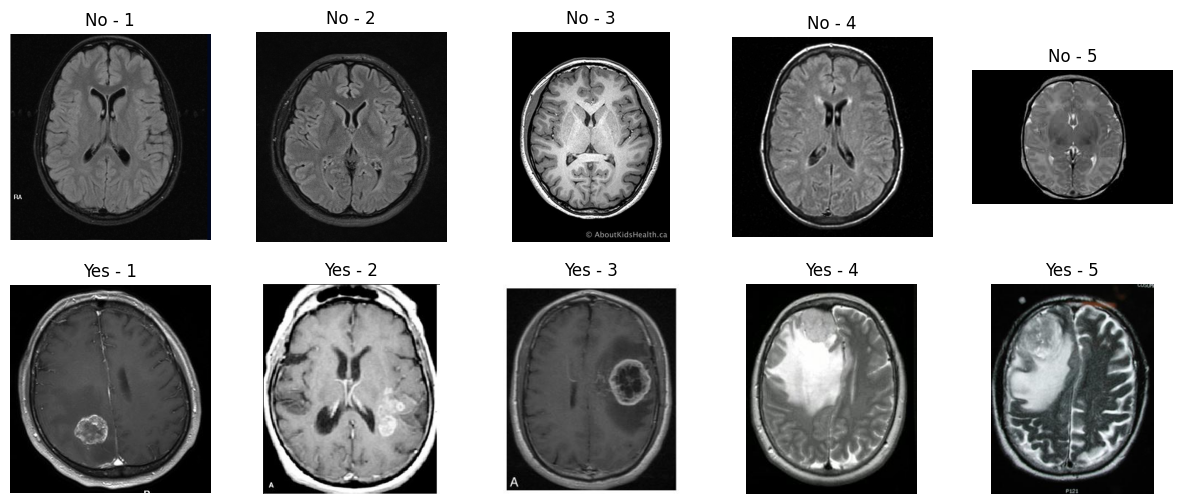

In [ ]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def plot_random_images(dataset_path, class_labels=('no', 'yes'), num_images=5):
    plt.figure(figsize=(15, 6))

    for class_label in class_labels:
        class_path = os.path.join(dataset_path, class_label)
        image_files = os.listdir(class_path)
        random_images = random.sample(image_files, num_images)

        for i, image_file in enumerate(random_images, start=1):
            plt.subplot(len(class_labels), num_images, (class_labels.index(class_label) * num_images) + i)

            img_path = os.path.join(class_path, image_file)
            img = mpimg.imread(img_path)
            plt.imshow(img, cmap='gray')

            plt.axis('off')
            plt.title(f'{class_label.capitalize()} - {i}')

    plt.show()

dataset_path = '/content/Training'
plot_random_images(dataset_path)

In [ ]:
from keras.applications import vgg16

img_rows, img_cols = 224, 224

vgg = vgg16.VGG16(weights="imagenet",
                  include_top=False,
                  input_shape=(img_rows, img_cols, 3))

for layer in vgg.layers:
  layer.trainable = False

for (i, layer) in enumerate(vgg.layers):
  print(str(i) + " " + layer.__class__.__name__, layer.trainable)

58889256/58889256 [==============================] - 1s 0us/step
0 InputLayer False
1 Conv2D False
2 Conv2D False
3 MaxPooling2D False
4 Conv2D False
5 Conv2D False
6 MaxPooling2D False
7 Conv2D False
8 Conv2D False
9 Conv2D False
10 MaxPooling2D False
11 Conv2D False
12 Conv2D False
13 Conv2D False
14 MaxPooling2D False
15 Conv2D False
16 Conv2D False
17 Conv2D False
18 MaxPooling2D False


In [ ]:
def structure_model(bottom_model, num_classes):
    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(512,activation='relu')(top_model)
    top_model = Dense(num_classes,activation='sigmoid')(top_model)
    return top_model

from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.models import Model

num_classes = 2

model_head = structure_model(vgg, num_classes)

model = Model(inputs = vgg.input, outputs = model_head)

print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
from tensorflow.keras.optimizers import Adam

opt = Adam(learning_rate=0.0001)

model.compile(loss='binary_crossentropy',optimizer=opt,metrics=['accuracy'])

from keras.callbacks import ModelCheckpoint

train_cb = ModelCheckpoint('model/', save_best_only=True)

history = model.fit(train_generator, validation_data=validation_generator, callbacks=[train_cb], epochs=5)

Epoch 1/5
7/7 [==============================] - 152s 22s/step - loss: 0.6325 - accuracy: 0.7143 - val_loss: 0.3577 - val_accuracy: 0.8800
Epoch 2/5
7/7 [==============================] - 162s 23s/step - loss: 0.3314 - accuracy: 0.8916 - val_loss: 0.2765 - val_accuracy: 0.9400
Epoch 3/5
7/7 [==============================] - 139s 20s/step - loss: 0.2364 - accuracy: 0.9163 - val_loss: 0.2661 - val_accuracy: 0.9400
Epoch 4/5
7/7 [==============================] - 148s 24s/step - loss: 0.1591 - accuracy: 0.9507 - val_loss: 0.2691 - val_accuracy: 0.9000
Epoch 5/5
7/7 [==============================] - 137s 20s/step - loss: 0.1167 - accuracy: 0.9754 - val_loss: 0.2675 - val_accuracy: 0.9000


In [ ]:
import numpy as np

(224, 224, 3)
(1, 224, 224, 3)


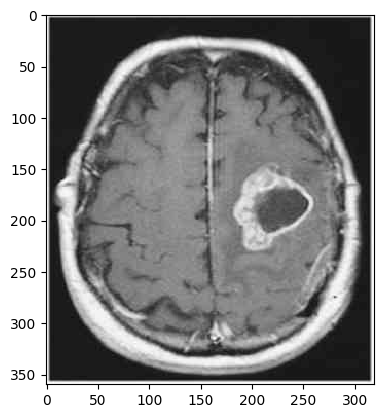

In [ ]:
img = cv2.imread('/content/Training/yes/Y10.jpg')
img = cv2.resize(img,(224,224))
img_array = np.array(img)
print(img_array.shape)

img_array = img_array.reshape(1,224,224,3)
print(img_array.shape)

from tensorflow.keras.preprocessing import image
img = image.load_img('/content/Training/yes/Y10.jpg')
plt.imshow(img,interpolation='nearest')
plt.show()

In [ ]:
a=model.predict(img_array)
indices = a.argmax()
indices

1/1 [==============================] - 1s 1s/step


0

# **Flower Implimentation**

In [2]:
!pip install flwr tensorflow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 421.5/421.5 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 52.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 51.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.2 MB/s eta 0:00:00
  Attempting uninstall: typer
    Found existing installation: typer 0.12.3
    Uninstalling typer-0.12.3:
      Successfully uninstalled typer-0.12.3
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
  Attempting uninstall: cryptography
    Found existing installation: cryptography 43.0.0
    Uninstalling cryptography-43.0.0:
      Successfully uninstalled cryptography-43.0.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This be

In [3]:
!pip install tensorflow flwr -U "flwr[simulation]" numpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.8/47.8 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.3/601.3 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.1/65.1 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 32.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.7/347.7 kB 21.7 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.25.2
    Uninstalling numpy-1.25.2:
      Successfully uninstal

# **Import Libraries and Define Model**

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import flwr as fl

# Define the VGG16-based model
def build_model():
    base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
    for layer in base_model.layers:
        layer.trainable = False

    top_model = base_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024, activation='relu')(top_model)
    top_model = Dense(1024, activation='relu')(top_model)
    top_model = Dense(512, activation='relu')(top_model)
    top_model = Dense(1, activation='sigmoid')(top_model)

    model = Model(inputs=base_model.input, outputs=top_model)
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
    return model


# **Load Data**

In [ ]:
def load_data():
    TRAIN_DIR = "/content/Training/"

    train_data_gen = ImageDataGenerator(validation_split=0.2, preprocessing_function=preprocess_input)

    train_generator = train_data_gen.flow_from_directory(
        TRAIN_DIR,
        target_size=(224, 224),
        color_mode='rgb',
        batch_size=32,
        shuffle=True,
        subset='training'
    )

    validation_generator = train_data_gen.flow_from_directory(
        TRAIN_DIR,
        target_size=(224, 224),
        color_mode='rgb',
        batch_size=32,
        shuffle=False,
        subset='validation'
    )

    return train_generator, validation_generator


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# **Flower Client**

In [ ]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, model, train_generator, validation_generator):
        self.model = model
        self.train_generator = train_generator
        self.validation_generator = validation_generator

    def get_parameters(self, config):
        return [val.numpy() for val in self.model.trainable_variables]

    def fit(self, parameters, config):
        self.model.set_weights(parameters)
        self.model.fit(self.train_generator, epochs=1, steps_per_epoch=len(self.train_generator))
        return self.get_parameters(config), len(self.train_generator), {}

    def evaluate(self, parameters, config):
        self.model.set_weights(parameters)
        loss, accuracy = self.model.evaluate(self.validation_generator)
        return loss, len(self.validation_generator), {"accuracy": accuracy}


# **Define Client Function**

In [ ]:
def client_fn(cid: str) -> FlowerClient:
    model = build_model()
    train_generator, validation_generator = load_data()
    return FlowerClient(model, train_generator, validation_generator)


# **Server and Simulation**

In [ ]:
import ray
print(ray.__version__)

2.10.0


In [ ]:
import tensorflow as tf
import flwr as fl
import numpy as np
from typing import List, Tuple, Dict
from collections import OrderedDict
import warnings
warnings.filterwarnings("ignore")

def weighted_average(metrics):
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]
    return {"accuracy": sum(accuracies) / sum(examples)}

strategy = fl.server.strategy.FedAvg(
    fraction_fit=1.0,
    fraction_evaluate=0.5,
    min_fit_clients=2,
    min_evaluate_clients=1,
    min_available_clients=2,
    evaluate_metrics_aggregation_fn=weighted_average,
)

# Start Flower simulation
fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=2,
    config=fl.server.ServerConfig(num_rounds=5),
    strategy=strategy,
    client_resources={"num_cpus": 1, "num_gpus": 0.0}
)


INFO :      Starting Flower simulation, config: num_rounds=5, no round_timeout
2024-07-25 16:10:48,176	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'node:__internal_head__': 1.0, 'node:172.28.0.12': 1.0, 'object_store_memory': 4014353203.0, 'memory': 8028706407.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 2 actors
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(pid=1418) 2024-07-25 16:10:55.189982: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=1418) 2024-07-25 16:10:55.297037: E external/local_xla/xla/stream

(ClientAppActor pid=1418) Downloading data from https://storage.googleapis.com/tensorflow/keras-applications/vgg16/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5
       0/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step
 4202496/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
23937024/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
46161920/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


(ClientAppActor pid=1418) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
INFO :      Received initial parameters from one random client
INFO :      Evaluating initial global parameters
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)
(ClientAppActor pid=1418) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1418) 
(ClientAppActor pid=1418)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1418)             entirely in future versions of Flower.
(ClientAppActor pid=1418)         


(ClientAppActor pid=1418) Found 203 images belonging to 2 classes.
(ClientAppActor pid=1418) Found 50 images belonging to 2 classes.


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 94, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 398, in get_client_result
    return self._fetch_future_result(cid)
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 279, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 2667, in get
    values, debugger_breakpoint = worker.get_obje

(ClientAppActor pid=1418) Found 203 images belonging to 2 classes.
(ClientAppActor pid=1418) Found 50 images belonging to 2 classes.


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 94, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 398, in get_client_result
    return self._fetch_future_result(cid)
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 279, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 2667, in get
    values, debugger_breakpoint = worker.get_obje

(ClientAppActor pid=1418) Found 50 images belonging to 2 classes. [repeated 12x across cluster]


ERROR :     Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 94, in _submit_job
    out_mssg, updated_context = self.actor_pool.get_client_result(
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 398, in get_client_result
    return self._fetch_future_result(cid)
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 279, in _fetch_future_result
    res_cid, out_mssg, updated_context = ray.get(
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 2667, in get
    values, debugger_breakpoint = worker.get_obje

In [11]:
# Importing necessary libraries
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input  # Pre-trained VGG16 model and preprocessing function
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # For data augmentation and loading
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense  # Layers for building the model
from tensorflow.keras.models import Model  # To define the model
from tensorflow.keras.optimizers import Adam  # Optimizer
import numpy as np  # For numerical operations
import flwr as fl  # Flower library for federated learning

# Define the VGG16-based model
def build_model(num_classes):
    # Load the pre-trained VGG16 model without the top classification layers
    base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

    # Freeze the layers of VGG16 to prevent them from being trained again
    for layer in base_model.layers:
        layer.trainable = False

    # Add new layers on top of the VGG16 model
    top_model = base_model.output
    top_model = GlobalAveragePooling2D()(top_model)  # Global average pooling layer
    top_model = Dense(1024, activation='relu')(top_model)  # Fully connected layer with 1024 units
    top_model = Dense(1024, activation='relu')(top_model)  # Another fully connected layer with 1024 units
    top_model = Dense(512, activation='relu')(top_model)  # Fully connected layer with 512 units

    # Add output layer based on the number of classes
    if num_classes == 2:
        top_model = Dense(1, activation='sigmoid')(top_model)  # Single output unit with sigmoid activation for binary classification
    else:
        top_model = Dense(num_classes, activation='softmax')(top_model)  # Softmax layer for multi-class classification

    # Create the complete model
    model = Model(inputs=base_model.input, outputs=top_model)

    # Compile the model with appropriate loss function and optimizer
    if num_classes == 2:
        model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
    else:
        model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

    return model

# Function to load training and validation data
def load_data():
    TRAIN_DIR = "/content/Training/"  # Directory containing training data

    # Data generator with data augmentation and preprocessing
    train_data_gen = ImageDataGenerator(validation_split=0.2, preprocessing_function=preprocess_input)

    # Load training data
    train_generator = train_data_gen.flow_from_directory(
        TRAIN_DIR,
        target_size=(224, 224),  # Resize images to 224x224 pixels
        color_mode='rgb',  # Load images in RGB color mode
        batch_size=32,  # Batch size of 32
        shuffle=True,  # Shuffle the training data
        subset='training',  # Use the training subset
        class_mode='binary'  # Binary classification mode; change to 'categorical' if using more than 2 classes
    )

    # Load validation data
    validation_generator = train_data_gen.flow_from_directory(
        TRAIN_DIR,
        target_size=(224, 224),  # Resize images to 224x224 pixels
        color_mode='rgb',  # Load images in RGB color mode
        batch_size=32,  # Batch size of 32
        shuffle=False,  # Do not shuffle the validation data
        subset='validation',  # Use the validation subset
        class_mode='binary'  # Binary classification mode; change to 'categorical' if using more than 2 classes
    )

    return train_generator, validation_generator

# Custom client class for federated learning
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, model, train_generator, validation_generator):
        self.model = model  # Initialize the model
        self.train_generator = train_generator  # Initialize the training data generator
        self.validation_generator = validation_generator  # Initialize the validation data generator

    def get_parameters(self, config):
        return self.model.get_weights()  # Return the model's weights

    def set_parameters(self, parameters):
        self.model.set_weights(parameters)  # Set the model's weights

    def fit(self, parameters, config):
        self.set_parameters(parameters)  # Set the model's weights
        self.model.fit(self.train_generator, epochs=1, steps_per_epoch=len(self.train_generator))  # Train the model for one epoch
        return self.get_parameters(config), len(self.train_generator), {}  # Return the updated weights and number of training samples

    def evaluate(self, parameters, config):
        self.set_parameters(parameters)  # Set the model's weights
        loss, accuracy = self.model.evaluate(self.validation_generator)  # Evaluate the model
        return loss, len(self.validation_generator), {"accuracy": accuracy}  # Return the loss, number of validation samples, and accuracy

# Function to create a FlowerClient instance
def client_fn(cid: str) -> FlowerClient:
    num_classes = 2  # Number of classes; adjust if using more than 2 classes
    model = build_model(num_classes)  # Build the model
    train_generator, validation_generator = load_data()  # Load the data
    return FlowerClient(model, train_generator, validation_generator)  # Return the FlowerClient instance

# Function to aggregate metrics from multiple clients
def weighted_average(metrics):
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]  # Calculate weighted accuracies
    examples = [num_examples for num_examples, _ in metrics]  # Collect the number of examples
    return {"accuracy": sum(accuracies) / sum(examples)}  # Return the weighted average accuracy

# Define the federated learning strategy
strategy = fl.server.strategy.FedAvg(
    fraction_fit=1.0,  # Use all clients for training
    fraction_evaluate=0.5,  # Use half of the clients for evaluation
    min_fit_clients=2,  # Minimum number of clients to train
    min_evaluate_clients=1,  # Minimum number of clients to evaluate
    min_available_clients=2,  # Minimum number of available clients
    evaluate_metrics_aggregation_fn=weighted_average,  # Function to aggregate metrics
)

# Start the federated learning simulation
fl.simulation.start_simulation(
    client_fn=client_fn,  # Specifies the client function
    num_clients=2,  # Number of clients
    config=fl.server.ServerConfig(num_rounds=5),  # Server configuration with 5 rounds
    strategy=strategy,  # Federated learning strategy
    client_resources={"num_cpus": 1, "num_gpus": 0.0}  # Resources allocated to each client
)


INFO :      Starting Flower simulation, config: num_rounds=5, no round_timeout
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-07-26 05:42:56,445	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'memory': 7969989428.0, 'object_store_memory': 3984994713.0, 'node:172.28.0.12': 1.0, 'node:__internal_head__': 1.0, 'CPU': 2.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 2 actors
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(pid=42627) 2024-07-26 05:43:14.350042: E external/loca

(ClientAppActor pid=42627) Found 203 images belonging to 2 classes.
(ClientAppActor pid=42627) Found 50 images belonging to 2 classes.


INFO :      Received initial parameters from one random client
INFO :      Evaluating initial global parameters
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)
(ClientAppActor pid=42627) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=42627) 
(ClientAppActor pid=42627)             This is a deprecated feature. It will be removed
(ClientAppActor pid=42627)             entirely in future versions of Flower.
(ClientAppActor pid=42627)         
(pid=42622) 2024-07-26 05:43:17.986389: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(ClientAppActor pid=42627) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `Nump

(ClientAppActor pid=42627) Found 203 images belonging to 2 classes.
(ClientAppActor pid=42627) Found 50 images belonging to 2 classes.


(ClientAppActor pid=42627) /usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
(ClientAppActor pid=42627)   self._warn_if_super_not_called()
(ClientAppActor pid=42622) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=42622)          [repeated 2x across cluster]
(ClientAppActor pid=42622)             This is a deprecated feature. It will be removed
(ClientAppActor pid=42622)             entirely in future versions of Flower.
(ClientAppActor pid=42622) WARNING :   Deprecation Warning: The `cl

1/7 ━━━━━━━━━━━━━━━━━━━━ 1:59 20s/step - accuracy: 0.3636 - loss: 1.1350
(ClientAppActor pid=42622) Found 50 images belonging to 2 classes. [repeated 2x across cluster]
1/7 ━━━━━━━━━━━━━━━━━━━━ 4:36 46s/step - accuracy: 0.3750 - loss: 1.1212
2/7 ━━━━━━━━━━━━━━━━━━━━ 3:38 44s/step - accuracy: 0.4958 - loss: 1.0893
2/7 ━━━━━━━━━━━━━━━━━━━━ 3:41 44s/step - accuracy: 0.4297 - loss: 1.0496
3/7 ━━━━━━━━━━━━━━━━━━━━ 2:52 43s/step - accuracy: 0.5261 - loss: 1.1438
3/7 ━━━━━━━━━━━━━━━━━━━━ 2:53 43s/step - accuracy: 0.4635 - loss: 1.0087
4/7 ━━━━━━━━━━━━━━━━━━━━ 1:40 34s/step - accuracy: 0.4855 - loss: 0.9801
5/7 ━━━━━━━━━━━━━━━━━━━━ 1:10 35s/step - accuracy: 0.5078 - loss: 0.9416 [repeated 2x across cluster]
6/7 ━━━━━━━━━━━━━━━━━━━━ 36s 37s/step - accuracy: 0.5226 - loss: 0.9100  [repeated 2x across cluster]
7/7 ━━━━━━━━━━━━━━━━━━━━ 271s 37s/step - accuracy: 0.5533 - loss: 0.8509
6/7 ━━━━━━━━━━━━━━━━━━━━ 42s 43s/step - accuracy: 0.5640 - loss: 1.0951 


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      configure_evaluate: strategy sampled 1 clients (out of 2)
(ClientAppActor pid=42622) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=42622)             This is a deprecated feature. It will be removed
(ClientAppActor pid=42622)             entirely in future versions of Flower.
(ClientAppActor pid=42622) /usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
(ClientAppActor pid=42622)   self._warn_if_super_not_called()
(

(ClientAppActor pid=42622) Found 203 images belonging to 2 classes.
(ClientAppActor pid=42622) Found 50 images belonging to 2 classes.
1/2 ━━━━━━━━━━━━━━━━━━━━ 23s 23s/step - accuracy: 0.9375 - loss: 0.3116
7/7 ━━━━━━━━━━━━━━━━━━━━ 271s 42s/step - accuracy: 0.5806 - loss: 1.0478


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


2/2 ━━━━━━━━━━━━━━━━━━━━ 34s 11s/step - accuracy: 0.9258 - loss: 0.3101


(ClientAppActor pid=42622) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=42622)             This is a deprecated feature. It will be removed
(ClientAppActor pid=42622)             entirely in future versions of Flower.
(ClientAppActor pid=42622)          [repeated 2x across cluster]
(ClientAppActor pid=42627) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=42627)             This is a deprecated feature. It will be removed
(ClientAppActor pid=42627)             entirely in future versions of Flower.


(ClientAppActor pid=42627) Found 203 images belonging to 2 classes.


(ClientAppActor pid=42622) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


1/7 ━━━━━━━━━━━━━━━━━━━━ 1:54 19s/step - accuracy: 0.9091 - loss: 0.2929
(ClientAppActor pid=42627) Found 50 images belonging to 2 classes. [repeated 3x across cluster]
1/7 ━━━━━━━━━━━━━━━━━━━━ 4:27 45s/step - accuracy: 0.8125 - loss: 0.3904
2/7 ━━━━━━━━━━━━━━━━━━━━ 3:19 40s/step - accuracy: 0.8266 - loss: 0.5233
2/7 ━━━━━━━━━━━━━━━━━━━━ 3:29 42s/step - accuracy: 0.7891 - loss: 0.4187
3/7 ━━━━━━━━━━━━━━━━━━━━ 2:45 41s/step - accuracy: 0.8178 - loss: 0.5337
3/7 ━━━━━━━━━━━━━━━━━━━━ 2:46 42s/step - accuracy: 0.7899 - loss: 0.4166
4/7 ━━━━━━━━━━━━━━━━━━━━ 1:36 32s/step - accuracy: 0.7934 - loss: 0.4136
5/7 ━━━━━━━━━━━━━━━━━━━━ 1:09 35s/step - accuracy: 0.7973 - loss: 0.4104 [repeated 2x across cluster]
6/7 ━━━━━━━━━━━━━━━━━━━━ 35s 36s/step - accuracy: 0.8028 - loss: 0.4048  [repeated 2x across cluster]
7/7 ━━━━━━━━━━━━━━━━━━━━ 266s 37s/step - accuracy: 0.8127 - loss: 0.3921
6/7 ━━━━━━━━━━━━━━━━━━━━ 41s 42s/step - accuracy: 0.8248 - loss: 0.5070 


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      configure_evaluate: strategy sampled 1 clients (out of 2)
(ClientAppActor pid=42622)          [repeated 4x across cluster]
(ClientAppActor pid=42622) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=42622)             This is a deprecated feature. It will be removed
(ClientAppActor pid=42622)             entirely in future versions of Flower.
(ClientAppActor pid=42627) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=42622) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, 

(ClientAppActor pid=42622) Found 203 images belonging to 2 classes.
(ClientAppActor pid=42622) Found 50 images belonging to 2 classes.
1/2 ━━━━━━━━━━━━━━━━━━━━ 27s 27s/step - accuracy: 0.8750 - loss: 0.3630
7/7 ━━━━━━━━━━━━━━━━━━━━ 268s 41s/step - accuracy: 0.8341 - loss: 0.4826


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


2/2 ━━━━━━━━━━━━━━━━━━━━ 37s 10s/step - accuracy: 0.9050 - loss: 0.3039


(ClientAppActor pid=42622) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=42622)             This is a deprecated feature. It will be removed
(ClientAppActor pid=42622)             entirely in future versions of Flower.
(ClientAppActor pid=42622)          [repeated 2x across cluster]
(ClientAppActor pid=42622) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=42622) Found 203 images belonging to 2 classes.
(ClientAppActor pid=42622) Found 50 images belonging to 2 classes.
1/7 ━━━━━━━━━━━━━━━━━━━━ 2:04 21s/step - accuracy: 1.0000 - loss: 0.1174
(ClientAppActor pid=42627) Found 50 images belonging to 2 classes. [repeated 2x across cluster]
1/7 ━━━━━━━━━━━━━━━━━━━━ 4:40 47s/step - accuracy: 0.9688 - loss: 0.1593
2/7 ━━━━━━━━━━━━━━━━━━━━ 3:16 39s/step - accuracy: 0.9419 - loss: 0.1938
2/7 ━━━━━━━━━━━━━━━━━━━━ 3:29 42s/step - accuracy: 0.9688 - loss: 0.1754
3/7 ━━━━━━━━━━━━━━━━━━━━ 2:45 41s/step - accuracy: 0.9124 - loss: 0.2442
3/7 ━━━━━━━━━━━━━━━━━━━━ 2:43 41s/step - accuracy: 0.9583 - loss: 0.1940
4/7 ━━━━━━━━━━━━━━━━━━━━ 2:02 41s/step - accuracy: 0.9039 - loss: 0.2563
4/7 ━━━━━━━━━━━━━━━━━━━━ 2:04 42s/step - accuracy: 0.9551 - loss: 0.1985
5/7 ━━━━━━━━━━━━━━━━━━━━ 1:22 41s/step - accuracy: 0.9001 - loss: 0.2599
5/7 ━━━━━━━━━━━━━━━━━━━━ 1:23 42s/step - accuracy: 0.9516 - loss: 0.2043
6/7 ━━━━━━━━━━━━━━━━━━━━ 40s 41s/step -

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      configure_evaluate: strategy sampled 1 clients (out of 2)
(ClientAppActor pid=42622) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=42622)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=42622)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=42622)          [repeated 4x across cluster]
(ClientAppActor pid=42627) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=42622) WARNING 

(ClientAppActor pid=42622) Found 203 images belonging to 2 classes.
(ClientAppActor pid=42622) Found 50 images belonging to 2 classes.
1/2 ━━━━━━━━━━━━━━━━━━━━ 20s 21s/step - accuracy: 0.8750 - loss: 0.3335
7/7 ━━━━━━━━━━━━━━━━━━━━ 269s 37s/step - accuracy: 0.9478 - loss: 0.2099


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)
(ClientAppActor pid=42622) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=42622)             This is a deprecated feature. It will be removed
(ClientAppActor pid=42622)             entirely in future versions of Flower.
(ClientAppActor pid=42622)          [repeated 2x across cluster]


2/2 ━━━━━━━━━━━━━━━━━━━━ 33s 12s/step - accuracy: 0.9050 - loss: 0.2764


(ClientAppActor pid=42627) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=42627)             This is a deprecated feature. It will be removed
(ClientAppActor pid=42627)             entirely in future versions of Flower.
(ClientAppActor pid=42622) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=42622) Found 203 images belonging to 2 classes.
(ClientAppActor pid=42622) Found 50 images belonging to 2 classes.
1/7 ━━━━━━━━━━━━━━━━━━━━ 4:38 46s/step - accuracy: 1.0000 - loss: 0.1202
(ClientAppActor pid=42627) Found 50 images belonging to 2 classes. [repeated 2x across cluster]
2/7 ━━━━━━━━━━━━━━━━━━━━ 3:25 41s/step - accuracy: 0.9531 - loss: 0.1681
1/7 ━━━━━━━━━━━━━━━━━━━━ 4:45 48s/step - accuracy: 1.0000 - loss: 0.1234
3/7 ━━━━━━━━━━━━━━━━━━━━ 2:44 41s/step - accuracy: 0.9444 - loss: 0.1763 [repeated 2x across cluster]
4/7 ━━━━━━━━━━━━━━━━━━━━ 1:35 32s/step - accuracy: 0.9927 - loss: 0.1261 [repeated 2x across cluster]
4/7 ━━━━━━━━━━━━━━━━━━━━ 2:04 41s/step - accuracy: 0.9368 - loss: 0.1841
5/7 ━━━━━━━━━━━━━━━━━━━━ 1:07 34s/step - accuracy: 0.9899 - loss: 0.1278
5/7 ━━━━━━━━━━━━━━━━━━━━ 1:22 41s/step - accuracy: 0.9332 - loss: 0.1887
6/7 ━━━━━━━━━━━━━━━━━━━━ 35s 35s/step - accuracy: 0.9867 - loss: 0.1309 
6/7 ━━━━━━━━━━━━━━━━━━━━ 41s 42s/step - accuracy: 0.92

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      configure_evaluate: strategy sampled 1 clients (out of 2)
(ClientAppActor pid=42622)          [repeated 4x across cluster]
(ClientAppActor pid=42622) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=42622)             This is a deprecated feature. It will be removed
(ClientAppActor pid=42622)             entirely in future versions of Flower.
(ClientAppActor pid=42627) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=42622) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, 

(ClientAppActor pid=42622) Found 203 images belonging to 2 classes.
(ClientAppActor pid=42622) Found 50 images belonging to 2 classes.
1/2 ━━━━━━━━━━━━━━━━━━━━ 20s 21s/step - accuracy: 0.9688 - loss: 0.2041


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.9544 - loss: 0.2355 
2/2 ━━━━━━━━━━━━━━━━━━━━ 33s 12s/step - accuracy: 0.9496 - loss: 0.2460


(ClientAppActor pid=42622) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=42622)             This is a deprecated feature. It will be removed
(ClientAppActor pid=42622)             entirely in future versions of Flower.
(ClientAppActor pid=42622)          [repeated 2x across cluster]
(ClientAppActor pid=42622) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=42622) Found 203 images belonging to 2 classes.
(ClientAppActor pid=42622) Found 50 images belonging to 2 classes.
1/7 ━━━━━━━━━━━━━━━━━━━━ 4:33 46s/step - accuracy: 1.0000 - loss: 0.1048
(ClientAppActor pid=42627) Found 50 images belonging to 2 classes. [repeated 2x across cluster]
2/7 ━━━━━━━━━━━━━━━━━━━━ 3:18 40s/step - accuracy: 0.9766 - loss: 0.1383
1/7 ━━━━━━━━━━━━━━━━━━━━ 4:49 48s/step - accuracy: 0.9688 - loss: 0.1575
3/7 ━━━━━━━━━━━━━━━━━━━━ 2:42 41s/step - accuracy: 0.9670 - loss: 0.1409 [repeated 2x across cluster]
3/7 ━━━━━━━━━━━━━━━━━━━━ 2:47 42s/step - accuracy: 0.9306 - loss: 0.1953
4/7 ━━━━━━━━━━━━━━━━━━━━ 2:02 41s/step - accuracy: 0.9635 - loss: 0.1415
5/7 ━━━━━━━━━━━━━━━━━━━━ 1:08 34s/step - accuracy: 0.9343 - loss: 0.1785 [repeated 2x across cluster]
5/7 ━━━━━━━━━━━━━━━━━━━━ 1:22 41s/step - accuracy: 0.9621 - loss: 0.1423
6/7 ━━━━━━━━━━━━━━━━━━━━ 35s 36s/step - accuracy: 0.9355 - loss: 0.1743 
6/7 ━━━━━━━━━━━━━━━━━━━━ 41s 41s/step - accuracy: 0.96

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      configure_evaluate: strategy sampled 1 clients (out of 2)
(ClientAppActor pid=42622) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=42622)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=42622)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=42622)          [repeated 4x across cluster]
(ClientAppActor pid=42627) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=42622) WARNING 

(ClientAppActor pid=42622) Found 203 images belonging to 2 classes.
(ClientAppActor pid=42622) Found 50 images belonging to 2 classes.


(ClientAppActor pid=42622) WARNING:tensorflow:5 out of the last 9 calls to <function TensorFlowTrainer.make_test_function.<locals>.one_step_on_iterator at 0x7a268ff49510> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/2 ━━━━━━━━━━━━━━━━━━━━ 26s 26s/step - accuracy: 0.9062 - loss: 0.2758
7/7 ━━━━━━━━━━━━━━━━━━━━ 267s 36s/step - accuracy: 0.9381 - loss: 0.1690


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 5 round(s) in 1535.14s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.30934929847717285
INFO :      		round 2: 0.2743756175041199
INFO :      		round 3: 0.2478940784931183
INFO :      		round 4: 0.2669338881969452
INFO :      		round 5: 0.22889423370361328
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'accuracy': [(1, 0.9200000166893005),
INFO :      	              (2, 0.9200000166893005),
INFO :      	              (3, 0.9200000166893005),
INFO :      	              (4, 0.9399999976158142),
INFO :      	              (5, 0.8999999761581421)]}
INFO :      


2/2 ━━━━━━━━━━━━━━━━━━━━ 37s 11s/step - accuracy: 0.9021 - loss: 0.2445


History (loss, distributed):
	round 1: 0.30934929847717285
	round 2: 0.2743756175041199
	round 3: 0.2478940784931183
	round 4: 0.2669338881969452
	round 5: 0.22889423370361328
History (metrics, distributed, evaluate):
{'accuracy': [(1, 0.9200000166893005),
              (2, 0.9200000166893005),
              (3, 0.9200000166893005),
              (4, 0.9399999976158142),
              (5, 0.8999999761581421)]}